<h1>Convolutional Neural Network (CNN) for RGB image classifier</h1>

<h3><b>Name:</b> Aw Shao Yang</h3>
<h3><b>Class:</b> DAAA/FT/2B/03</h3>
<h3><b>Student ID:</b> p2012126</h3>

<p>
In part B of this project, we are expected to implement an image classifier using a deep learning convolutional neural network but now for RGB images from the Cifar 10 dataset, hence I have decided to operate and create the network using the TensorFlow 2.0 library.
In order to create the Nerual Network model, I have decoded to import the following tools which would help in the creation of my model
</p>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D,Flatten, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

## Data Exploration

Here I have done some dataset exploration for this dataset since we are unaware of what we are handling and this is to get a basic idea of the type of data in the dataset

Since our dataset is based on images, we will have plot their pixels using matploltlibs graphs to view what object images we are classifying. To get a quick view of the images, I have plotted the first 25 entries of our train X dataset. Through the images we see that: 
* Our images do not seem to have a common theme on what we are predicting. Some are about different types of natural animals. While others appear to be about vehicles.
* Our images are colored. And not black and white 
* There appears to be more than 2 categories

170508288/170498071 [==============================] - 11s 0us/step


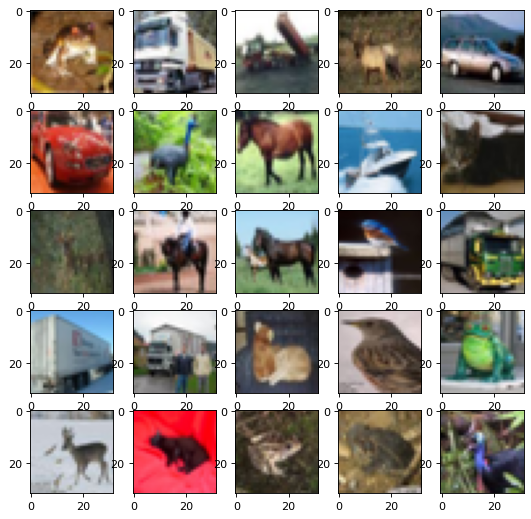

In [2]:

from tensorflow.keras.datasets import cifar10

seed = 99
np.random.seed(seed)
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#Data images
plt.figure(figsize=(8,8 ), dpi=80)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

Through external research about the dataset we are handling, I have found that the classes of the images in this dataset are as follows
- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck

Here is some more information of the images that we are classifying 

In [ ]:
print(f"Train sizes: (X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test sizes: (X_test: {X_test.shape},  (y_test: {y_test.shape}")
print("Unique Categories:", np.unique(y_train))

Train sizes: (X_train: (50000, 32, 32, 3), y_train: (50000, 1)
Test sizes: (X_test: (10000, 32, 32, 3),  (y_test: (10000, 1)
Unique Categories: [0 1 2 3 4 5 6 7 8 9]



Through analysing the dataset sizes and categories, we see that:

* All the images are of 32 x 32 pixels (larger than fashion mnist)
* In our training set, we have 50000 images to train our model while our test set has 10000 images
* Our dataset consists of 10 different categories,a mixture of animals and different types of vehicles 
* The images are RGB hence the 3 channel it has 

Since our model has 10 different categories, we would set the final output layer to have only 10 nodes, 1 node for each category.

Next lets take a look at the distribution of the categories on the dataset's classes 

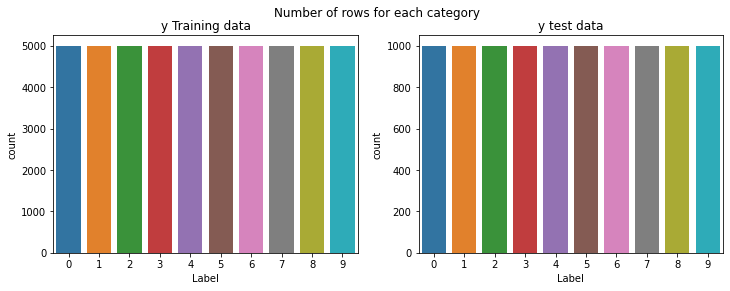

In [ ]:
import seaborn as sns
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12, 4))

fig.suptitle('Number of rows for each category')
ax1.set_title('y Training data')
ax1.set_xlabel('Label')
sns.countplot(x = y_train.reshape(-1), ax=ax1)

ax2.set_title('y test data')
ax2.set_xlabel('Label')
sns.countplot(x = y_test.reshape(-1), ax=ax2)

Here we see that this dataset is good as we have a equal count distrbution of each category  meaning that there is no case of imbalanced classes in our dataset. Next we check to make sure that no null values exists in our image datasets to ensure that we have proper images for image classification training and testing

In [ ]:
print("Null values in X_train: ", np.isnan(np.sum(X_train)))
print("Null values in y_train: ", np.isnan(np.sum(y_train)))
print("Null values in X_test: ", np.isnan(np.sum(X_test)))
print("Null values in y_test: ", np.isnan(np.sum(y_test)))

Null values in X_train:  False
Null values in y_train:  False
Null values in X_test:  False
Null values in y_test:  False


Next I took a look at the pixel distribution of one of the images. We see that the images only have a pixel range from 0 to 255, hence when normalizing the image pixels, we will need to divide by 255. We see that most of the pixel values are around 30 to 150 

Highest Pixel Value: 255
Lowes Pixel Value: 0


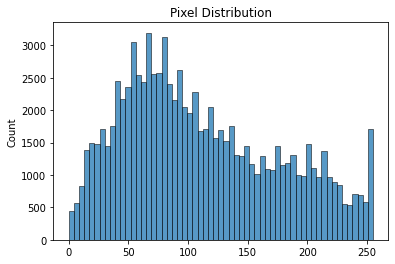

In [ ]:
plt.title('Pixel Distribution')
sns.histplot(X_train[0:30].reshape(-1))
print("Highest Pixel Value:", max(X_train[0].reshape(-1)))
print("Lowes Pixel Value:", min(X_train[0].reshape(-1)))
plt.show()

In [4]:
image = X_train[0]
b, g, r    = image[:, :, 0], image[:, :, 1], image[:, :, 2] # For RGB image

fig, (ax1, ax2, ax3)

array([[ 59,  43,  50, ..., 158, 152, 148],
       [ 16,   0,  18, ..., 123, 119, 122],
       [ 25,  16,  49, ..., 118, 120, 109],
       ...,
       [208, 201, 198, ..., 160,  56,  53],
       [180, 173, 186, ..., 184,  97,  83],
       [177, 168, 179, ..., 216, 151, 123]], dtype=uint8)

### Convolutional Neural Network
For this dataset I had just decided to already start on making a CNN instead of making a Basic Neural Network 



#### Data Preperation 
Before creating and fitting our data, we must first make the data appropriate for CNN model training and testing 

Since the shape of the dataset is already 50000 x 32 x 32 x 3, here we do not need to reshape the training data to make it have the channel. However here I still converted it from an int into a float as well as did data normalization for the pixels it to rescale it between [0 and 1]

In [5]:
X_train_cn = X_train.astype('float32')
X_test_cn = X_test.astype('float32')

X_train_cn = X_train_cn/255.0
X_test_cn = X_test_cn/255.0

From data exploration, we saw that the output variable is an integer from 0 to 9. However, since this is a multi-class classification problem. As such, it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix. of 10 columns

In [6]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#number of output nodes
num_of_classes = y_test.shape[1]
y_train[:5,:]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

#### CNN Architecture and Training 
Now is where I created the CNN architecture for our models to have a baseline CNN model for training and testing to see where it stands in terms of performance in predicting the images from Cifar10 using the image pixels What I have done for my baseline model here was a CNN with:
* Convolutional layer with 32 filters and kernal of 3x3
* Pooling layer of 2x2 patches 
* A flatten layer
* A fully connected layer with 64 Neurons and Relu function 
* 30 epoch, 100 batchsize, adam optimizer 

In [ ]:
cn_model1 = Sequential()
cn_model1.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
cn_model1.add(MaxPooling2D(pool_size=(2,2)))
cn_model1.add(Flatten())
cn_model1.add(Dense(64, activation='relu'))
cn_model1.add(Dense(10, activation='softmax'))
cn_model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn1 = cn_model1.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model1.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn1.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 16s 9ms/step - loss: 1.5869 - accuracy: 0.4360 - val_loss: 1.3556 - val_accuracy: 0.5325
Epoch 2/30
500/500 [==============================] - 4s 7ms/step - loss: 1.2757 - accuracy: 0.5550 - val_loss: 1.2668 - val_accuracy: 0.5510
Epoch 3/30
500/500 [==============================] - 4s 8ms/step - loss: 1.1742 - accuracy: 0.5900 - val_loss: 1.2102 - val_accuracy: 0.5748
Epoch 4/30
500/500 [==============================] - 4s 8ms/step - loss: 1.1006 - accuracy: 0.6162 - val_loss: 1.1269 - val_accuracy: 0.6046
Epoch 5/30
500/500 [==============================] - 4s 7ms/step - loss: 1.0557 - accuracy: 0.6336 - val_loss: 1.1309 - val_accuracy: 0.6036
Epoch 6/30
500/500 [==============================] - 4s 8ms/step - loss: 1.0132 - accuracy: 0.6485 - val_loss: 1.1465 - val_accuracy: 0.5999
Epoch 7/30
500/500 [==============================] - 4s 7ms/step - loss: 0.9687 - accuracy: 0.6647 - val_loss: 1.0970 - val_accuracy: 0.6139
Epoch

In [ ]:
cn_model1.save('model/basic_model')

INFO:tensorflow:Assets written to: model/basic_model/assets


Through the results above we see that the model that we have built here has performed quite poorly in its predictions. We were only able to get a highest val accuracy of around 0.64 ~ 0.65 as the training accuracy continuously increases over time causing the massive overfitting, and quite early overfitting. Hence we will need to try and improve the model 

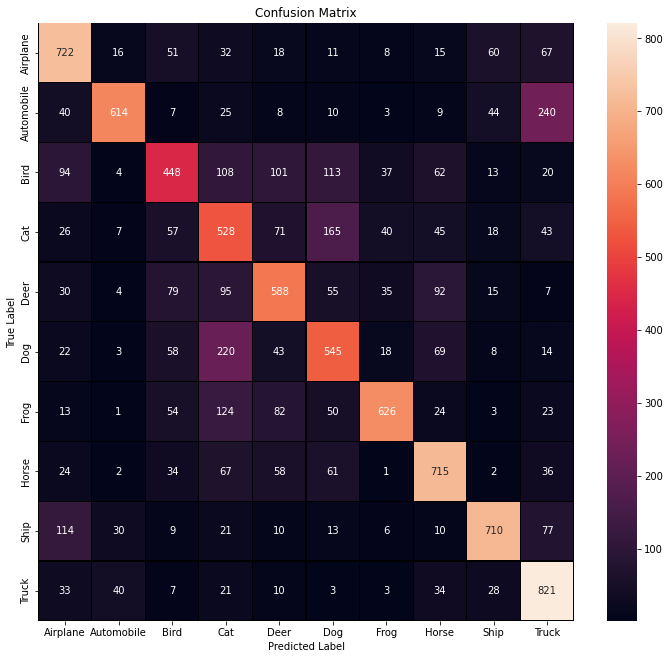

In [ ]:
cn_model1 = load_model('model/basic_model')
y_pred = cn_model1.predict(X_test_cn)
y_pred_classes = np.argmax(y_pred, axis= 1)
y_true = np.argmax(y_test, axis=1 )
cm = confusion_matrix(y_true, y_pred_classes)

f,ax = plt.subplots(figsize = (12,11))
cm_df = pd.DataFrame(cm, columns= ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'], index= ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'])
sns.heatmap(cm_df, annot=True, linewidths=0.1, linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

As for the performance of the model based on the heatmap of its confusion matrix, we see that 
* The most errored label is the cat label, where the model mainly confuses cats for other animals.
* Many mammals have been predicted incorrectly, most likely due to similar appearances.
* Best animal to be predicted was the Horse.
* Vehicles generally performed better as compared to animals 
* Worst vehicle predicted was Automobile 
* Overall best guessed class was Truck

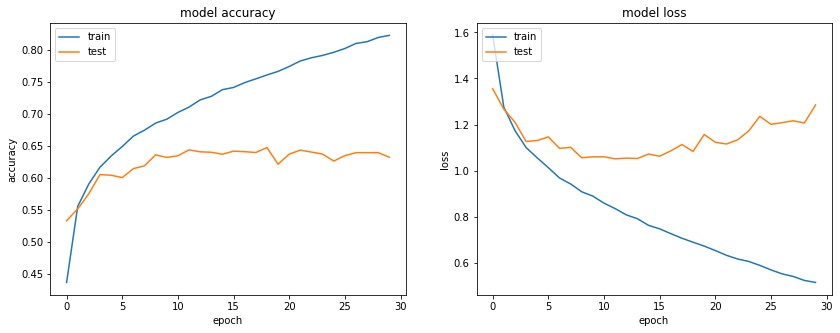

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn1.history['accuracy'])
ax1.plot(history_cn1.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn1.history['loss'])
ax2.plot(history_cn1.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

Based on the epoch accuracy plots, we see serious overfitting over the number of epochs of the model. From the baseline model that we have here, we see that there are many problems with it. There is quite low validation accuracy and as the model grows, so does the overfitting.

### Hyper parameter optimization
Now we will have to hyper tune the model to see if we can achieve a model with less overfitting and higher accuracy scores for testing. My first aim at hyper tuning was to try and increase the test accuracy of the model before trying to lower its overfitting

The first way to hyper tune our model would be tuning its nodes and layers to try an achieve a better model to improve the scores and accuracy. The layers here that we can tune would be the:
*  Hidden Layers and their nodes
*  Conv2D layers, their nodes and their kernal sizes 
*  Pooling layers

#### Convolutional layers and Pooling Sets
The first method that I have decided to hypertune the model for this dataset was through increasing the number of Convolutional and Maxpooling sets that the model has.

In conv2d, its filter and kernal detects a specific type of feature in the input, then applies the filter systematically across the entire input image allowing the filter to discover that feature anywhere in the image.

As for the pooling layer, it reduces the spatial size of the representation to reduce the amount of parameters and computation in the network. It provides the ability to learn invariant features and also acts as a regularizer to further reduce the problem of overfitting. 


#### 2 Conv2D and Pooling Layers
My first attempt of a more complex model was a model with:
* Conv2D (32 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2))
* Conv2D (64 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2))


In [ ]:
cn_model2 = Sequential()
cn_model2.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
cn_model2.add(MaxPooling2D(pool_size=(2,2)))
cn_model2.add(Conv2D(64, (3,3), activation='relu'))
cn_model2.add(MaxPooling2D(pool_size=(2,2)))
cn_model2.add(Flatten())
cn_model2.add(Dense(64, activation='relu'))
cn_model2.add(Dense(10, activation='softmax'))
cn_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn2 = cn_model2.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model2.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn2.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 6s 12ms/step - loss: 1.5525 - accuracy: 0.4428 - val_loss: 1.2898 - val_accuracy: 0.5435
Epoch 2/30
500/500 [==============================] - 6s 11ms/step - loss: 1.2300 - accuracy: 0.5690 - val_loss: 1.1635 - val_accuracy: 0.5913
Epoch 3/30
500/500 [==============================] - 6s 11ms/step - loss: 1.0778 - accuracy: 0.6249 - val_loss: 1.0530 - val_accuracy: 0.6357
Epoch 4/30
500/500 [==============================] - 6s 12ms/step - loss: 0.9872 - accuracy: 0.6575 - val_loss: 1.0454 - val_accuracy: 0.6299
Epoch 5/30
500/500 [==============================] - 6s 12ms/step - loss: 0.9243 - accuracy: 0.6816 - val_loss: 0.9966 - val_accuracy: 0.6561
Epoch 6/30
500/500 [==============================] - 6s 12ms/step - loss: 0.8779 - accuracy: 0.6973 - val_loss: 0.9332 - val_accuracy: 0.6776
Epoch 7/30
500/500 [==============================] - 6s 12ms/step - loss: 0.8349 - accuracy: 0.7136 - val_loss: 0.9098 - val_accuracy: 0.6889

As we see from above, through the introduction of a second set of Conv2D and MaxPooling, we see an overall improvement in the models accuracy. Initially with a base model of just 1 set, we were only able to obtain an val accuracy score of up to 0.65 but through the use of 2 sets, we see that we are now able to score up to 0.7. This was a significant increase in the test accuracy, hence I will keep it to my model

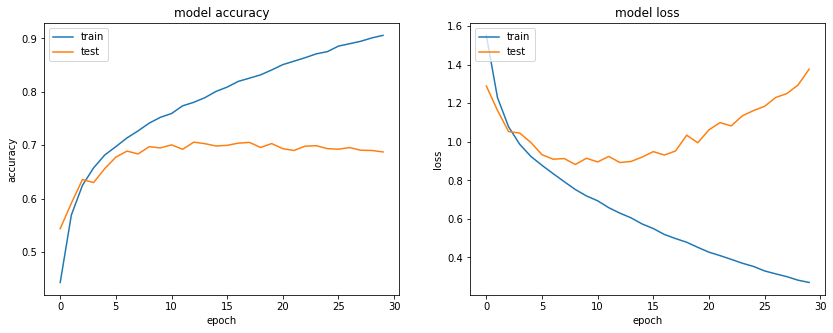

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn2.history['accuracy'])
ax1.plot(history_cn2.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn2.history['loss'])
ax2.plot(history_cn2.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

Through the epoch graphs, we also notice that the overfitting starts slightly  later for this model. 



Since the increase of the number of Conv2D sets helped, I decided to also try 3 sets. Here the model I tried was:
* Conv2D (32 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2))
* Conv2D (64 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2))
* Conv2D (128 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2))


In [ ]:
cn_model3 = Sequential()
cn_model3.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
cn_model3.add(MaxPooling2D(pool_size=(2,2)))
cn_model3.add(Conv2D(64, (3,3), activation='relu'))
cn_model3.add(MaxPooling2D(pool_size=(2,2)))
cn_model3.add(Conv2D(128, (3,3), activation='relu'))
cn_model3.add(MaxPooling2D(pool_size=(2,2)))
cn_model3.add(Flatten())
cn_model3.add(Dense(64, activation='relu'))
cn_model3.add(Dense(10, activation='softmax'))
cn_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn3 = cn_model3.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model3.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn3.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 8s 14ms/step - loss: 1.6714 - accuracy: 0.3880 - val_loss: 1.3768 - val_accuracy: 0.4958
Epoch 2/30
500/500 [==============================] - 7s 14ms/step - loss: 1.2685 - accuracy: 0.5479 - val_loss: 1.1736 - val_accuracy: 0.5848
Epoch 3/30
500/500 [==============================] - 7s 14ms/step - loss: 1.1059 - accuracy: 0.6133 - val_loss: 1.0990 - val_accuracy: 0.6128
Epoch 4/30
500/500 [==============================] - 7s 14ms/step - loss: 0.9967 - accuracy: 0.6531 - val_loss: 1.0248 - val_accuracy: 0.6427
Epoch 5/30
500/500 [==============================] - 7s 14ms/step - loss: 0.9225 - accuracy: 0.6803 - val_loss: 0.9401 - val_accuracy: 0.6761
Epoch 6/30
500/500 [==============================] - 7s 14ms/step - loss: 0.8646 - accuracy: 0.7004 - val_loss: 0.9417 - val_accuracy: 0.6747
Epoch 7/30
500/500 [==============================] - 7s 14ms/step - loss: 0.8050 - accuracy: 0.7213 - val_loss: 0.9114 - val_accuracy: 0.6911

Now with a model of 3 sets of Conv2D and Maxpooling, we observe lesser but still improvement towards the validation accuracy of our model, around (2% improvement). Despite the increase being lesser as compared to the increase when we tried 2 sets instead of 1 set, it is still improvement nonetheless and still relatively significant. Hence I will keep this as part of my model

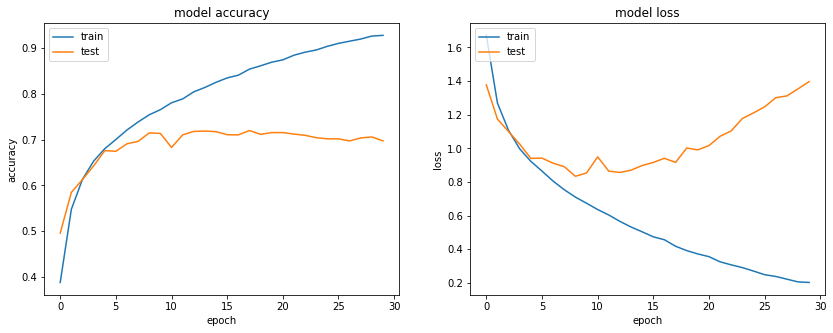

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn3.history['accuracy'])
ax1.plot(history_cn3.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn3.history['loss'])
ax2.plot(history_cn3.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

We see that the around epoch 6 the model starts overfitting and the gap continuously increase as the number of epochs increases



From the results above, I decided to try to increase the number of Conv2D and MaxPooling sets again to 4 sets now instead of 3. This is to see if there is still any significant improvement if I continue increasing the sets. Here is the architecture:
* Conv2D (32 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2))
* Conv2D (64 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2))
* Conv2D (128 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2))  
* Conv2D (256 filters) kernal 3x3 
* MaxPooling2D (pool_size (2,2)) 

Below there should be an error

In [ ]:
cn_model4 = Sequential()
cn_model4.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
cn_model4.add(MaxPooling2D(pool_size=(2,2)))
cn_model4.add(Conv2D(64, (3,3), activation='relu'))
cn_model4.add(MaxPooling2D(pool_size=(2,2)))
cn_model4.add(Conv2D(128, (3,3), activation='relu'))
cn_model4.add(MaxPooling2D(pool_size=(2,2)))
cn_model4.add(Conv2D(256, (3,3), activation='relu'))
cn_model4.add(MaxPooling2D(pool_size=(2,2)))
cn_model4.add(Flatten())
cn_model4.add(Dense(64, activation='relu'))
cn_model4.add(Dense(10, activation='softmax'))
cn_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn4 = cn_model4.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model4.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn4.history['val_accuracy'])*100)

ValueError: ignored

However through trying to implement this architecture, we run into some issues with adding the 4th layer. This was due to a negative dimension size caused from the decreasing image size after every Conv2D and Max Pooling layer it passes through. 

#### Inclusion of Padding
In order to be able to have the 4 layer, I would need to introduce padding to my Conv2D model to maintain the original shape of the data. 

Since adding padding to an image processed can also allow for a more accurate analysis of images, before adding the 4th layer, I decided to tryout padding first to see what happens to my model after the padding so that we can properly evaluate whether the changes was due to the padding or due to the 4th layer introduction to the model.





In [ ]:
cn_model4 = Sequential()
cn_model4.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu', padding = "same"))
cn_model4.add(MaxPooling2D(pool_size=(2,2)))
cn_model4.add(Conv2D(64, (3,3), activation='relu', padding = "same"))
cn_model4.add(MaxPooling2D(pool_size=(2,2)))
cn_model4.add(Conv2D(128, (3,3), activation='relu', padding = "same"))
cn_model4.add(MaxPooling2D(pool_size=(2,2)))
cn_model4.add(Flatten())
cn_model4.add(Dense(64, activation='relu'))
cn_model4.add(Dense(10, activation='softmax'))
cn_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn4 = cn_model4.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model4.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn4.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 9s 16ms/step - loss: 1.5601 - accuracy: 0.4344 - val_loss: 1.2865 - val_accuracy: 0.5404
Epoch 2/30
500/500 [==============================] - 8s 15ms/step - loss: 1.1390 - accuracy: 0.5987 - val_loss: 1.0428 - val_accuracy: 0.6324
Epoch 3/30
500/500 [==============================] - 8s 15ms/step - loss: 0.9476 - accuracy: 0.6700 - val_loss: 1.0149 - val_accuracy: 0.6551
Epoch 4/30
500/500 [==============================] - 8s 15ms/step - loss: 0.8465 - accuracy: 0.7086 - val_loss: 0.8570 - val_accuracy: 0.7052
Epoch 5/30
500/500 [==============================] - 8s 16ms/step - loss: 0.7626 - accuracy: 0.7366 - val_loss: 0.8509 - val_accuracy: 0.7098
Epoch 6/30
500/500 [==============================] - 8s 15ms/step - loss: 0.7021 - accuracy: 0.7595 - val_loss: 0.8156 - val_accuracy: 0.7278
Epoch 7/30
500/500 [==============================] - 8s 15ms/step - loss: 0.6423 - accuracy: 0.7780 - val_loss: 0.8260 - val_accuracy: 0.7167

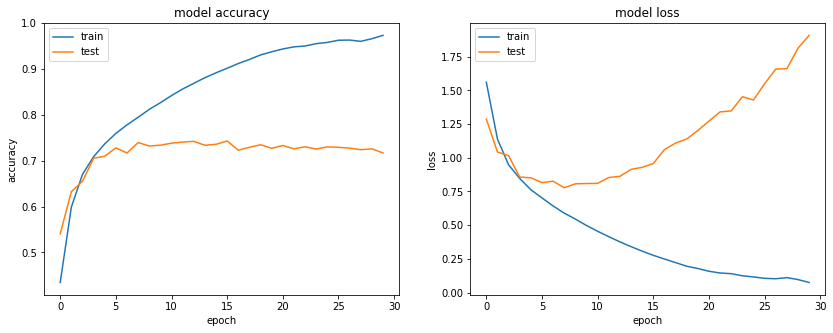

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn4.history['accuracy'])
ax1.plot(history_cn4.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn4.history['loss'])
ax2.plot(history_cn4.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

After including padding into the convolutional layers of my model, we see slight improvement in the val accuracy of the model. Now we are able obtain a score of 74% (2% improvement). However after introducing padding into the model, we observe that the overfitting is even more extreme now as the training score reaches an accuracy score that is alot higher (near 0.97)



Now lets take a look if including a 4 set of Conv2D and Maxpooling will lead to model improvement

In [ ]:
cn_model5 = Sequential()
cn_model5.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu', padding = "same"))
cn_model5.add(MaxPooling2D(pool_size=(2,2)))
cn_model5.add(Conv2D(64, (3,3), activation='relu', padding = "same"))
cn_model5.add(MaxPooling2D(pool_size=(2,2)))
cn_model5.add(Conv2D(128, (3,3), activation='relu', padding = "same"))
cn_model5.add(MaxPooling2D(pool_size=(2,2)))
cn_model5.add(Conv2D(256, (3,3), activation='relu', padding = "same"))
cn_model5.add(MaxPooling2D(pool_size=(2,2)))
cn_model5.add(Flatten())
cn_model5.add(Dense(64, activation='relu'))
cn_model5.add(Dense(10, activation='softmax'))
cn_model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn5 = cn_model5.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model5.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn5.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 10s 18ms/step - loss: 1.5070 - accuracy: 0.4494 - val_loss: 1.2238 - val_accuracy: 0.5582
Epoch 2/30
500/500 [==============================] - 8s 17ms/step - loss: 1.0830 - accuracy: 0.6172 - val_loss: 0.9740 - val_accuracy: 0.6627
Epoch 3/30
500/500 [==============================] - 8s 16ms/step - loss: 0.8882 - accuracy: 0.6886 - val_loss: 0.8657 - val_accuracy: 0.7010
Epoch 4/30
500/500 [==============================] - 8s 17ms/step - loss: 0.7465 - accuracy: 0.7390 - val_loss: 0.8008 - val_accuracy: 0.7289
Epoch 5/30
500/500 [==============================] - 8s 16ms/step - loss: 0.6419 - accuracy: 0.7775 - val_loss: 0.7952 - val_accuracy: 0.7267
Epoch 6/30
500/500 [==============================] - 8s 16ms/step - loss: 0.5400 - accuracy: 0.8106 - val_loss: 0.7955 - val_accuracy: 0.7435
Epoch 7/30
500/500 [==============================] - 8s 16ms/step - loss: 0.4580 - accuracy: 0.8416 - val_loss: 0.8023 - val_accuracy: 0.736

Through the use of another layer, we see another slight increase in val accuracy as now we can score val accuracies up to 0.75 hence I included a 4th layer to the model. However we see that as  the model increases in Maxpool and Conv2D sets, the increase in val accuracy also decreases after an implementation of another layer, so I decided not to increase the number of sets further. 

#### Stacked Conv2D layers
The next way I tried to improve the model by complexity was through just adding more layers of Conv2D. Meaning that I tried to stack Conv2D layers on top of each other. By stacking just Conv2D layers, I feel that it has more flexibility in expressing non-linear transformations without loosing information as Maxpooling removes information, so by having multiple Conv layers, we can build up better representations of the data without losing all of the spatial information too quickly. The architecture is:
* Conv2D (32 filters) kernal 3x3 (padding: same)
* Conv2D (32 filters) kernal 3x3 (padding: same)
* MaxPooling2D (pool_size (2,2))
* Conv2D (64 filters) kernal 3x3 (padding: same)
* Conv2D (64 filters) kernal 3x3 (padding: same)
* MaxPooling2D (pool_size (2,2))
* Conv2D (128 filters) kernal 3x3 (padding: same)
* Conv2D (128 filters) kernal 3x3 (padding: same)
* MaxPooling2D (pool_size (2,2))
* Conv2D (256 filters) kernal 3x3 (padding: same)
* Conv2D (256 filters) kernal 3x3 (padding: same)
* MaxPooling2D (pool_size (2,2))

In [ ]:
cn_model6 = Sequential()
cn_model6.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu' , padding='same'))
cn_model6.add(Conv2D(32, (3,3), activation='relu' , padding='same'))
cn_model6.add(MaxPooling2D(pool_size=(2,2)))
cn_model6.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model6.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model6.add(MaxPooling2D(pool_size=(2,2)))
cn_model6.add(Conv2D(128, (3,3), activation='relu' , padding='same'))
cn_model6.add(Conv2D(128, (3,3), activation='relu' , padding='same'))
cn_model6.add(MaxPooling2D(pool_size=(2,2)))
cn_model6.add(Conv2D(256, (3,3), activation='relu' , padding='same'))
cn_model6.add(Conv2D(256, (3,3), activation='relu' , padding='same'))
cn_model6.add(MaxPooling2D(pool_size=(2,2)))
cn_model6.add(Flatten())
cn_model6.add(Dense(64, activation='relu'))
cn_model6.add(Dense(10, activation='softmax'))
cn_model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn6 = cn_model6.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model6.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn6.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 19s 36ms/step - loss: 1.6569 - accuracy: 0.3789 - val_loss: 1.2913 - val_accuracy: 0.5192
Epoch 2/30
500/500 [==============================] - 17s 35ms/step - loss: 1.1381 - accuracy: 0.5874 - val_loss: 0.9881 - val_accuracy: 0.6519
Epoch 3/30
500/500 [==============================] - 17s 35ms/step - loss: 0.8700 - accuracy: 0.6926 - val_loss: 0.8280 - val_accuracy: 0.7104
Epoch 4/30
500/500 [==============================] - 18s 35ms/step - loss: 0.7028 - accuracy: 0.7553 - val_loss: 0.7743 - val_accuracy: 0.7314
Epoch 5/30
500/500 [==============================] - 17s 35ms/step - loss: 0.5800 - accuracy: 0.7972 - val_loss: 0.6945 - val_accuracy: 0.7641
Epoch 6/30
500/500 [==============================] - 18s 35ms/step - loss: 0.4800 - accuracy: 0.8310 - val_loss: 0.6722 - val_accuracy: 0.7795
Epoch 7/30
500/500 [==============================] - 17s 35ms/step - loss: 0.3861 - accuracy: 0.8644 - val_loss: 0.7320 - val_accuracy:

Through the results, we see that after stacking the Convolutional layers of 2 per set with paddig, we observe another increase in the model's val accuracy. Now the model has a max val accuracy of < 0.78.

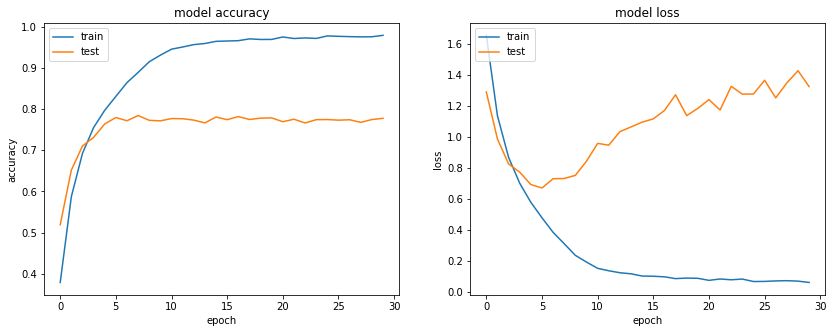

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn6.history['accuracy'])
ax1.plot(history_cn6.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn6.history['loss'])
ax2.plot(history_cn6.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

From the epoch plots above, we still see that the model overfits quite a lot as the model is able to score up to 90+ in training accuracy but only a max of 78% in test accuracy. 



Due to an increase in of val accuracy by the increase of convolutional layers, I decided to try with another increase in Convolutional layers to see if any more improvements will be made to the model

In [ ]:
cn_model = Sequential()
cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(32, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(32, (3,3), activation='relu' , padding='same'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))
cn_model.add(Flatten())
cn_model.add(Dense(64, activation='relu'))
cn_model.add(Dense(10, activation='softmax'))
cn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn = cn_model.fit(X_train_cn, y_train, epochs=5, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn.history['val_accuracy'])*100)

Epoch 1/5
500/500 [==============================] - 56s 51ms/step - loss: 2.3027 - accuracy: 0.0998 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/5
500/500 [==============================] - 26s 53ms/step - loss: 2.3027 - accuracy: 0.0982 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/5
500/500 [==============================] - 26s 53ms/step - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/5
500/500 [==============================] - 25s 50ms/step - loss: 2.3027 - accuracy: 0.0997 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/5
500/500 [==============================] - 26s 53ms/step - loss: 2.3027 - accuracy: 0.0996 - val_loss: 2.3026 - val_accuracy: 0.1000
Minimum Error: 89.99999985098839


Through the use of 3 Convolutional layers per max pooling we witness horrible performance of our model in both the traing and test data. Now the models are unable to score anyrhing more than 10 % and has an error of about 90%. Hence I have chosen to stick with only 2 Convolutional layers per stack in my model

#### Hidden layer tuning
My next attempt at improving the model was through tuning its hidden layers. My current model's hidden layers only consist of 1 layer with 64 nodes, here I tried to increase the number of hidden layers to 2

Model Architecture (Hidden layers): 
* 64 nodes 
* 64 nodes 


In [ ]:
cn_model = Sequential()
cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(32, (3,3), activation='relu' , padding='same'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))

cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))

cn_model.add(MaxPooling2D(pool_size=(2,2)))
cn_model.add(Flatten())
cn_model.add(Dense(64, activation='relu'))
cn_model.add(Dense(64, activation='relu'))
cn_model.add(Dense(10, activation='softmax'))
cn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn = cn_model.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 18s 35ms/step - loss: 1.7423 - accuracy: 0.3418 - val_loss: 1.3459 - val_accuracy: 0.5057
Epoch 2/30
500/500 [==============================] - 17s 34ms/step - loss: 1.1587 - accuracy: 0.5799 - val_loss: 1.0652 - val_accuracy: 0.6251
Epoch 3/30
500/500 [==============================] - 17s 34ms/step - loss: 0.9020 - accuracy: 0.6784 - val_loss: 0.8224 - val_accuracy: 0.7127
Epoch 4/30
500/500 [==============================] - 17s 35ms/step - loss: 0.7348 - accuracy: 0.7412 - val_loss: 0.8365 - val_accuracy: 0.7165
Epoch 5/30
500/500 [==============================] - 17s 35ms/step - loss: 0.6153 - accuracy: 0.7841 - val_loss: 0.7110 - val_accuracy: 0.7570
Epoch 6/30
500/500 [==============================] - 17s 34ms/step - loss: 0.5209 - accuracy: 0.8164 - val_loss: 0.7012 - val_accuracy: 0.7690
Epoch 7/30
500/500 [==============================] - 17s 34ms/step - loss: 0.4308 - accuracy: 0.8485 - val_loss: 0.6887 - val_accuracy:

After increasing the number of layers to 2, we see little to no improvements in terms of val accuracy. The highest accuracy we can obtain is around 0.77. But since there does notseem to be any deprovements to the validation accuracy, I decided to then try a third layer to see if there will be any improvements.

Model Architecture (Hidden Layers)
- 64 nodes
- 64 nodes
- 64 nodes



In [ ]:
cn_model = Sequential()
cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(32, (3,3), activation='relu' , padding='same'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))

cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))
cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))

cn_model.add(MaxPooling2D(pool_size=(2,2)))
cn_model.add(Flatten())
cn_model.add(Dense(64, activation='relu'))
cn_model.add(Dense(64, activation='relu'))
cn_model.add(Dense(64, activation='relu'))
cn_model.add(Dense(10, activation='softmax'))
cn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn = cn_model.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 19s 36ms/step - loss: 1.8041 - accuracy: 0.3117 - val_loss: 1.4002 - val_accuracy: 0.4754
Epoch 2/30
500/500 [==============================] - 17s 35ms/step - loss: 1.2259 - accuracy: 0.5504 - val_loss: 1.0997 - val_accuracy: 0.6056
Epoch 3/30
500/500 [==============================] - 17s 34ms/step - loss: 0.9802 - accuracy: 0.6476 - val_loss: 0.9468 - val_accuracy: 0.6640
Epoch 4/30
500/500 [==============================] - 18s 35ms/step - loss: 0.8022 - accuracy: 0.7172 - val_loss: 0.8156 - val_accuracy: 0.7166
Epoch 5/30
500/500 [==============================] - 17s 35ms/step - loss: 0.6755 - accuracy: 0.7622 - val_loss: 0.8037 - val_accuracy: 0.7245
Epoch 6/30
500/500 [==============================] - 17s 35ms/step - loss: 0.5721 - accuracy: 0.7992 - val_loss: 0.7195 - val_accuracy: 0.7541
Epoch 7/30
500/500 [==============================] - 17s 34ms/step - loss: 0.4915 - accuracy: 0.8266 - val_loss: 0.7335 - val_accuracy:

Through the inclusion of 1 more layer, we see that the model also did not have any further improvements. In fact looking at the scores for val accuracy, we see that the model could still only score up to 0.77 and was no longer able to score up till 0.78. Hence I decided not to add any more hidden layers to my model as I felt that it would most likely worsen my model even further

#### Nodes Adjustment 
Next I will try to improve the model by adjusting the number of nodes on just that one layer. The number node I have tried are 32,64,128, 256 and 512

In [ ]:
nodes = [32,64,128,256,512]
for i in nodes:
  cn_model = Sequential()
  cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu' , padding='same'))
  cn_model.add(Conv2D(32, (3,3), activation='relu' , padding='same'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))

  cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
  cn_model.add(Conv2D(64, (3,3), activation='relu' , padding='same'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))

  cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))
  cn_model.add(Conv2D(128, (3,3), activation='relu' , padding='same'))

  cn_model.add(MaxPooling2D(pool_size=(2,2)))

  cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))
  cn_model.add(Conv2D(256, (3,3), activation='relu' , padding='same'))

  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Flatten())
  cn_model.add(Dense(i, activation='relu'))
  cn_model.add(Dense(10, activation='softmax'))
  cn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history_cn = cn_model.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test), verbose=0)
  scores = cn_model.evaluate(X_test_cn,  y_test, verbose=0)
  print(f"Nodes: {i}, Minimum Error:", 100-max(history_cn.history['val_accuracy'])*100)

Nodes: 32, Minimum Error: 22.079998254776
Nodes: 64, Minimum Error: 22.109997272491455
Nodes: 128, Minimum Error: 23.240000009536743
Nodes: 256, Minimum Error: 22.850000858306885
Nodes: 512, Minimum Error: 23.39000105857849


From the results above, we see that generally, higher node amounts in the dense layers of my model tend to score lower accuracy score. Hence I have decided to maintain my number of nodes to just be 64 nodes 

Through all the attempts to make my model better in terms of validation accuracy, I felt that I should now start trying to reduce the overfitting of my model

#### Reducing Overfitting (Batch Normalization)
The first method that I thought of to reduce the overfitting was to introduce Batch Normalization into my current model. 

How I attempted to do it was have a Batch Normalization layer for each Convolutional layer before activation and as well as for the hidden layer in my model to apply its slight regularization effects. This is to also increase the speed of training in my model :

* Conv2D (32 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (32 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))

* Conv2D (64 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (64 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))

* Conv2D (128 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (128 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))

* Conv2D (256 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (256 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))

* Hidden layer (64 nodes) Batch Normalization (Activation Relu)

In [ ]:
cn_model7 = Sequential()
cn_model7.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(Conv2D(32, (3,3) , padding='same'))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(MaxPooling2D(pool_size=(2,2)))

cn_model7.add(Conv2D(64, (3,3) , padding='same'))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(Conv2D(64, (3,3) , padding='same'))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(MaxPooling2D(pool_size=(2,2)))

cn_model7.add(Conv2D(128, (3,3) , padding='same'))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(Conv2D(128, (3,3) , padding='same'))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(MaxPooling2D(pool_size=(2,2)))

cn_model7.add(Conv2D(256, (3,3) , padding='same'))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(Conv2D(256, (3,3) , padding='same'))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(MaxPooling2D(pool_size=(2,2)))
cn_model7.add(Flatten())
cn_model7.add(Dense(64))
cn_model7.add(BatchNormalization())
cn_model7.add(Activation('relu'))
cn_model7.add(Dense(10, activation='softmax'))
cn_model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn7 = cn_model7.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model7.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn7.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 24s 44ms/step - loss: 1.1466 - accuracy: 0.5895 - val_loss: 1.3419 - val_accuracy: 0.5569
Epoch 2/30
500/500 [==============================] - 22s 43ms/step - loss: 0.7062 - accuracy: 0.7552 - val_loss: 0.9107 - val_accuracy: 0.6967
Epoch 3/30
500/500 [==============================] - 22s 43ms/step - loss: 0.5428 - accuracy: 0.8113 - val_loss: 0.8243 - val_accuracy: 0.7278
Epoch 4/30
500/500 [==============================] - 21s 43ms/step - loss: 0.4286 - accuracy: 0.8524 - val_loss: 0.7768 - val_accuracy: 0.7458
Epoch 5/30
500/500 [==============================] - 21s 43ms/step - loss: 0.3391 - accuracy: 0.8821 - val_loss: 0.6327 - val_accuracy: 0.7915
Epoch 6/30
500/500 [==============================] - 21s 43ms/step - loss: 0.2587 - accuracy: 0.9099 - val_loss: 0.8896 - val_accuracy: 0.7444
Epoch 7/30
500/500 [==============================] - 22s 43ms/step - loss: 0.1938 - accuracy: 0.9315 - val_loss: 1.0044 - val_accuracy:

Through adding layers of Batch Normalization into our model, we see that we actually managed to improve the validation accuracy of the model. The initial validation accuracy without Batch Normalization was around < = 0.78. However through using batch normalization in the Conv2D and Dense layers of the model, we managed to bring up the score by another 4 %, getting a val accuracy of 0.82. 

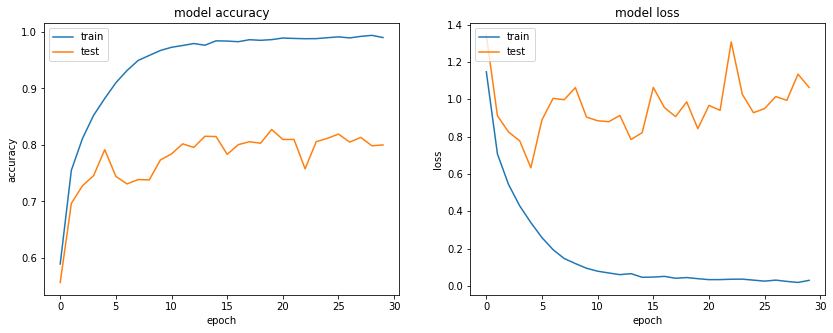

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn7.history['accuracy'])
ax1.plot(history_cn7.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn7.history['loss'])
ax2.plot(history_cn7.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

However when we look at the epoch plot, we see that we did not manage to deal with the problem of over fitting in the model. It appears that the small regularization from the Batch Normalization was just insufficient for our model to prevent overfitting. Another thing we see is that through introducing Batch normalization, our model fluctuates a lot more in val accuracy as compared to before



#### Reducing Overfitting (Dropout)
The next method that I have thought of to reduce the overfitting of our model was adding dropout layers for the model to drop out some nodes in certain parts of the model

To get a sense of how much overfitting reduction will happen through dropout, I decided to just add 1 layer of dropout in the Dense layer to see what will happen

In [ ]:
cn_model = Sequential()
cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(Conv2D(32, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(64, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(Conv2D(64, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(128, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(Conv2D(128, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))

cn_model.add(Conv2D(256, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(Conv2D(256, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))
cn_model.add(Flatten())
cn_model.add(Dense(64))
cn_model.add(BatchNormalization())
cn_model.add(Activation('relu'))
cn_model.add(Dropout(0.2))

cn_model.add(Dense(10, activation='softmax'))
cn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn = cn_model.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 23s 43ms/step - loss: 1.2241 - accuracy: 0.5622 - val_loss: 1.2295 - val_accuracy: 0.5518
Epoch 2/30
500/500 [==============================] - 21s 42ms/step - loss: 0.7557 - accuracy: 0.7382 - val_loss: 0.8333 - val_accuracy: 0.7136
Epoch 3/30
500/500 [==============================] - 21s 41ms/step - loss: 0.5856 - accuracy: 0.7981 - val_loss: 0.9841 - val_accuracy: 0.6788
Epoch 4/30
500/500 [==============================] - 21s 42ms/step - loss: 0.4660 - accuracy: 0.8395 - val_loss: 0.7920 - val_accuracy: 0.7455
Epoch 5/30
500/500 [==============================] - 21s 42ms/step - loss: 0.3715 - accuracy: 0.8729 - val_loss: 0.7634 - val_accuracy: 0.7605
Epoch 6/30
500/500 [==============================] - 21s 42ms/step - loss: 0.2955 - accuracy: 0.8986 - val_loss: 0.8499 - val_accuracy: 0.7504
Epoch 7/30
500/500 [==============================] - 21s 42ms/step - loss: 0.2309 - accuracy: 0.9182 - val_loss: 0.7778 - val_accuracy:

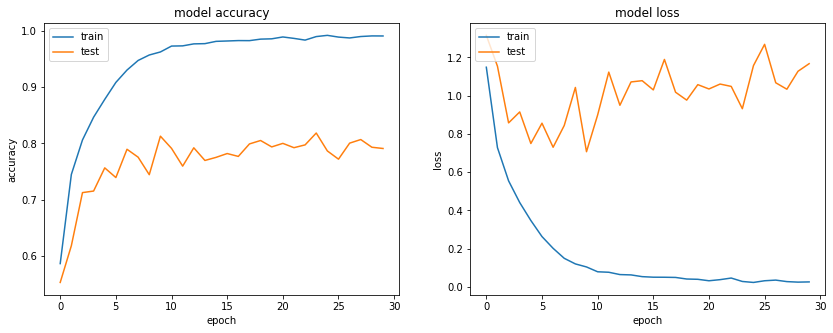

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn7.history['accuracy'])
ax1.plot(history_cn7.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn7.history['loss'])
ax2.plot(history_cn7.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

Through adding 1 layer we managed to improve the model very slightly. However the model is still over fitting quite a lot as we can see from the epoch plot above. 

In order to increase the regularization of the model, I decided to try increasing the number dropout layers in my model. Previously I only used 1 layer in my hidden layer, so now I will be adding 1 layer after every MaxPooling layer to reduce the overfitting even further 

Model:
* Conv2D (32 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (32 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))
* Dropout(0.2)

* Conv2D (64 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (64 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))
* Dropout(0.2)

* Conv2D (128 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (128 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))
* Dropout(0.2)

* Conv2D (256 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (256 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))
* Dropout(0.2)

* Hidden layer (128 nodes) Batch Normalization (Activation Relu)
* Dropout(0.2)

In [ ]:
cn_model8 = Sequential()
cn_model8.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Conv2D(32, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(MaxPooling2D(pool_size=(2,2)))
cn_model8.add(Dropout(0.2))

cn_model8.add(Conv2D(64, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Conv2D(64, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(MaxPooling2D(pool_size=(2,2)))
cn_model8.add(Dropout(0.2))

cn_model8.add(Conv2D(128, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Conv2D(128, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(MaxPooling2D(pool_size=(2,2)))
cn_model8.add(Dropout(0.2))

cn_model8.add(Conv2D(256, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Conv2D(256, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(MaxPooling2D(pool_size=(2,2)))
cn_model8.add(Dropout(0.2))

cn_model8.add(Flatten())
cn_model8.add(Dense(64))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Dropout(0.2))

cn_model8.add(Dense(10, activation='softmax'))
cn_model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn8 = cn_model8.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model8.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn8.history['val_accuracy'])*100)

Epoch 1/30
500/500 [==============================] - 24s 44ms/step - loss: 1.4017 - accuracy: 0.4928 - val_loss: 1.4057 - val_accuracy: 0.5035
Epoch 2/30
500/500 [==============================] - 22s 43ms/step - loss: 0.9183 - accuracy: 0.6757 - val_loss: 1.0441 - val_accuracy: 0.6416
Epoch 3/30
500/500 [==============================] - 22s 43ms/step - loss: 0.7463 - accuracy: 0.7378 - val_loss: 0.7406 - val_accuracy: 0.7449
Epoch 4/30
500/500 [==============================] - 21s 43ms/step - loss: 0.6430 - accuracy: 0.7761 - val_loss: 0.7332 - val_accuracy: 0.7535
Epoch 5/30
500/500 [==============================] - 22s 43ms/step - loss: 0.5734 - accuracy: 0.8015 - val_loss: 0.6518 - val_accuracy: 0.7808
Epoch 6/30
500/500 [==============================] - 22s 43ms/step - loss: 0.5162 - accuracy: 0.8224 - val_loss: 0.6602 - val_accuracy: 0.7782
Epoch 7/30
500/500 [==============================] - 22s 43ms/step - loss: 0.4684 - accuracy: 0.8378 - val_loss: 0.6140 - val_accuracy:

When we increase the number of dropouts, we see that the model has increased in validation accuracy. Now the highest prediction validation accuracy that the model is able to make is around 0.86 (4~5% improvement) which is good

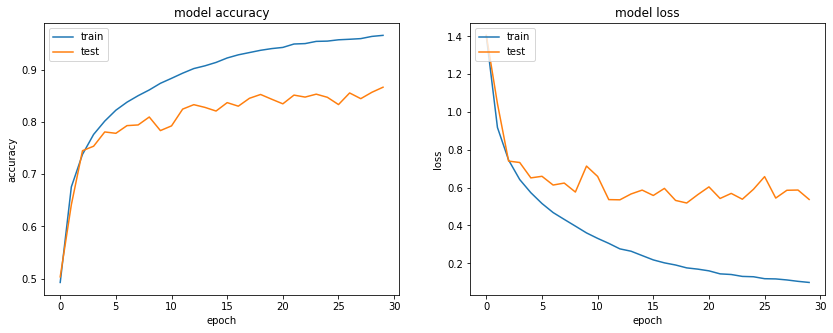

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn8.history['accuracy'])
ax1.plot(history_cn8.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn8.history['loss'])
ax2.plot(history_cn8.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

Through analysing the model acuracy for training and testing data, we see that we managed to reduce quite a bit of overfitting after introducing all those dropout layers to the model. However this is still  not sufficient as we still see a big gap between training and validation.

 Hence we should tune the models dropout rates to see if it will help us in reducing the amount of overfitting for our model



In [ ]:
models = []
drop_outs = [0.3 ,0.4, 0.45, 0.5]
for i in drop_outs:
  print("Dropout: ", i, '......' )
  cn_model = Sequential()
  cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Conv2D(32, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(i))

  cn_model.add(Conv2D(64, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Conv2D(64, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(i))

  cn_model.add(Conv2D(128, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Conv2D(128, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(i))

  cn_model.add(Conv2D(256, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Conv2D(256, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(i))

  cn_model.add(Flatten())
  cn_model.add(Dense(64))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Dropout(i))

  cn_model.add(Dense(10, activation='softmax'))
  cn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history_cn = cn_model.fit(X_train_cn, y_train, epochs=50, batch_size=100, validation_data=(X_test_cn, y_test), verbose=0)
  models.append(history_cn)
  print("Minimum error: ", 100-max(history_cn.history['val_accuracy'])*100)

Dropout:  0.3 ......
Minimum error:  12.779998779296875
Dropout:  0.4 ......
Minimum error:  12.790000438690186
Dropout:  0.45 ......
Minimum error:  13.169997930526733
Dropout:  0.5 ......
Minimum error:  14.249998331069946


These are the highest validation accuracy results of each model meant for us to see if adjusting the dropout rates will have any negative effects on the model's validation accuracy. This is so that we can adjust the dropout rates that is allows us to have the least overfitting but still have the best validation accurracy when training and testing the model

We see that the when we increase the models dropout rates, they are generally able to  score around similar validation accuracies. However the lower dropout rates tend to be somewhat better in their val accuracy performance

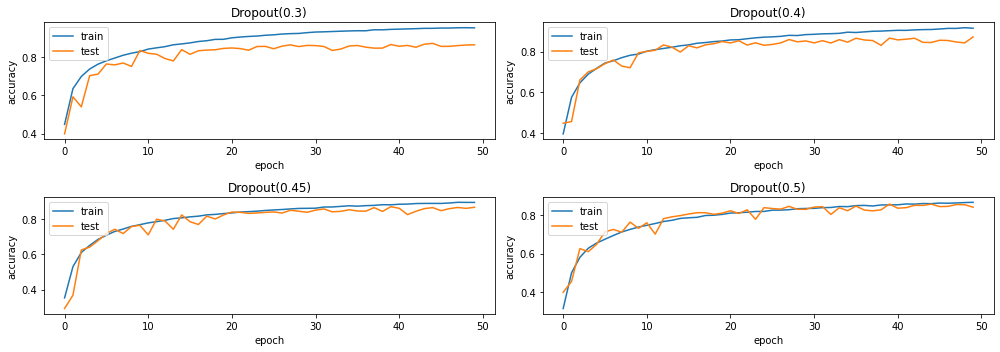

In [ ]:
fig, ((ax1, ax2) ,(ax3,ax4)) = plt.subplots(2,2, figsize=(14,5))
ax1.plot(models[0].history['accuracy'])
ax1.plot(models[0].history['val_accuracy'])
ax1.set_title('Dropout(0.3)')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(models[1].history['accuracy'])
ax2.plot(models[1].history['val_accuracy'])
ax2.set_title('Dropout(0.4)')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

ax3.plot(models[2].history['accuracy'])
ax3.plot(models[2].history['val_accuracy'])
ax3.set_title('Dropout(0.45)')
ax3.set_ylabel('accuracy')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

ax4.plot(models[3].history['accuracy'])
ax4.plot(models[3].history['val_accuracy'])
ax4.set_title('Dropout(0.5)')
ax4.set_ylabel('accuracy')
ax4.set_xlabel('epoch')
ax4.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

Looking at the plots above, we see that as the dropout rates are increased, the model seems to overfit even lesser. Here we see that the dropout rate of 0.5 is the one that has the least overfitting. However looking at the accuracy scores from the results above, we see that 0.5 dropout rate tends to score a lower val accuracy hence I have decided to incorporate only a maximum dropout rate of 0.3 
so as to not affect the accuracy. But how will we be able to regularize and lessen the overfitting even further? Well the answer would be to try using Data Augmentation which would be covered later in the model.

Here is where I end off model complexity tuning and move on with the layer parameters tuning

#### Learning rate and Optimizer Adjustment
Next I tried to hypertune the learning rate of our model. It controls how big the jumps your model makes, and from there, how quickly it learn.

* A smaller learning rate means more reliable training, but longer time 
* A high learning rate, may not converge or even diverge, weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse. Thus we need to find the optimal learning rate which can quickly find the minimum loss.

Here I adjusted the learning rate of the different optimizers to see if we can increase the efficienecy or accuracy of the model training. Why I did both learning rate and optimizer was due to optimizers performing differently on different learning rates. The opimizers chosen are:
* Adam
* RMSprop
* Stochastic Gradient Decsent (SGD)

In [ ]:
learning_rates = [
                  Adam(0.0001), Adam(0.001), Adam(0.01), Adam(0.1),
                  SGD(0.0001), SGD(0.001), SGD(0.01), SGD(0.1),
                  RMSprop(0.0001), RMSprop(0.001), RMSprop(0.01), RMSprop(0.1)
                  ]
learning_rates_str = [
                  'Adam(0.0001)', 'Adam(0.001)', 'Adam(0.01)', 'Adam(0.1)',
                  'SGD(0.0001)', 'SGD(0.001)', 'SGD(0.01)', 'SGD(0.1)',
                  'RMSprop(0.0001)', 'RMSprop(0.001)','RMSprop(0.01)', 'RMSprop(0.1)'
                  ]
learning_rate_df = pd.DataFrame({'Learning_rate': [], 'Minimum Error': []})
for i in range(len(learning_rates)): 
  cn_model = Sequential()
  cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Conv2D(32, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(64, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Conv2D(64, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(128, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Conv2D(128, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(256, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Conv2D(256, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Flatten())
  cn_model.add(Dense(64))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('relu'))
  cn_model.add(Dropout(0.3))

  cn_model.add(Dense(10, activation='softmax'))
  cn_model.compile(loss='categorical_crossentropy', optimizer=learning_rates[i], metrics=['accuracy'])
  history_cn = cn_model.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test),verbose=0)
  row_df = pd.DataFrame({'Learning_rate': [learning_rates_str[i]], 'Minimum Error': [100-max(history_cn.history['val_accuracy'])*100]})
  print(f'{i}')
  learning_rate_df = learning_rate_df.append(row_df)
learning_rate_df

0
1
2
3
4
5
6
7
8
9
10
11


,Learning_rate,Minimum Error
0,Adam(0.0001),18.239999
0,Adam(0.001),13.929999
0,Adam(0.01),14.099997
0,Adam(0.1),20.730001
0,SGD(0.0001),84.320000
0,SGD(0.001),64.640000
0,SGD(0.01),23.680001
0,SGD(0.1),15.319997
0,RMSprop(0.0001),19.389999
0,RMSprop(0.001),13.830000


Looking at the results above, we observe that the optimizer that allowed the model to train and predict the best was the RMSporp optimizer with 0.001 learning rate. But keep in mind this difference between Adam and RMSprop in terms of validation accuracy is only very slightly different


#### Activation Function Adjustment
Next would be trying to improve the model by using different types of activation functions. The functions that I have chosen to tryout are the 'sigmoid', 'tanh', 'relu' and 'leaky_relu'

In [ ]:
activation = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
activation_df = pd.DataFrame({'Activation': [], 'Minimum Error': []})
for i in activation:
  print("Activation Function:",i)
  cn_model = Sequential()
  cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(Conv2D(32, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(64, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(Conv2D(64, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(128, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(Conv2D(128, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(256, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(Conv2D(256, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Flatten())
  cn_model.add(Dense(64))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation(i))
  cn_model.add(Dropout(0.3))

  cn_model.add(Dense(10, activation='softmax'))
  cn_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(0.001), metrics=['accuracy'])
  history_cn = cn_model.fit(X_train_cn, y_train, epochs=30, batch_size=100, validation_data=(X_test_cn, y_test), verbose=0)
  scores = cn_model.evaluate(X_test_cn,  y_test, verbose=0)
  row_df = pd.DataFrame({'Activation': [i], 'Minimum Error': [100-max(history_cn.history['val_accuracy'])*100]})
  print(i, "Done")
  activation_df = activation_df.append(row_df)

activation_df

Activation Function: sigmoid
sigmoid Done
Activation Function: tanh
tanh Done
Activation Function: relu
relu Done
Activation Function: leaky_relu
leaky_relu Done


,Activation,Minimum Error
0,sigmoid,21.539998
0,tanh,18.220001
0,relu,13.800001
0,leaky_relu,13.760000


From the results above, we see that Leaky ReLu appears to score very slightly  better than the current activation function I have for my model (ReLu) most probably by chance. However I still changed the models activation function from ReLu to Leaky Relu

#### Batchsize Adjustment

Here I tried to tune the model based on its batch size for training.

In [ ]:
batch_size = [50, 100, 150, 200, 300]
batch_df = pd.DataFrame({'Batch Size': [], 'Minimum Error': []})
for i in batch_size:
  print(i)
  cn_model = Sequential()
  cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(Conv2D(32, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(64, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(Conv2D(64, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(128, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(Conv2D(128, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Conv2D(256, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(Conv2D(256, (3,3) , padding='same'))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(MaxPooling2D(pool_size=(2,2)))
  cn_model.add(Dropout(0.3))

  cn_model.add(Flatten())
  cn_model.add(Dense(64))
  cn_model.add(BatchNormalization())
  cn_model.add(Activation('leaky_relu'))
  cn_model.add(Dropout(0.3))


  cn_model.add(Dense(10, activation='softmax'))
  cn_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(0.001), metrics=['accuracy'])
  history_cn = cn_model.fit(X_train_cn, y_train, epochs=30, batch_size=i, validation_data=(X_test_cn, y_test), verbose=0)
  scores = cn_model.evaluate(X_test_cn,  y_test, verbose=0)
  row_df = pd.DataFrame({'Batch Size': [i], 'Minimum Error': [100-max(history_cn.history['val_accuracy'])*100]})
  print(i, "Done")
  batch_df = batch_df.append(row_df)

batch_df

50
50 Done
100
100 Done
150
150 Done
200
200 Done
300
300 Done


,Batch Size,Minimum Error
0,50.0,14.029998
0,100.0,13.590002
0,150.0,14.010000
0,200.0,13.910002
0,300.0,14.579999


For the batch size, we see a batch size of 100 doing slightly better than the other batch sizes, hence I stuck with 100 for my model

#### Convolutional Neural Network with Data Augmentation
Here I attempted to obtain a more accurate model through the usage of data augmentation to create more data to train my model with. This was meant to try an increase the validation accuracy of the model as well as reduce the models overfitting even further. 

The image transformations that I have done for the model was 
- Rotate image
- Zoom image
- Shift image horizontally and vertically

However after adding the augmented data, we see that the amount of epochs it takes for the model to reach its consistent maximum accuracy has increased significantly. Initially the amount of epochs for the model to reach its highest accuracy range was within 30 epochs. But now the epochs has risen up to around 90 ~ 100 epochs to reach its highest accuracy as well as be able to score it consistently

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range = 15,
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
datagen.fit(X_train_cn)

In [ ]:
cn_model = Sequential()
cn_model.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(Conv2D(32, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))
cn_model.add(Dropout(0.25))

cn_model.add(Conv2D(64, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(Conv2D(64, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))
cn_model.add(Dropout(0.25))

cn_model.add(Conv2D(128, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(Conv2D(128, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))
cn_model.add(Dropout(0.25))

cn_model.add(Conv2D(256, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(Conv2D(256, (3,3) , padding='same'))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(MaxPooling2D(pool_size=(2,2)))
cn_model.add(Dropout(0.25))

cn_model.add(Flatten())
cn_model.add(Dense(64))
cn_model.add(BatchNormalization())
cn_model.add(Activation('leaky_relu'))
cn_model.add(Dropout(0.5))
cn_model.add(Dense(10, activation='softmax'))
cn_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(0.001), metrics=['accuracy'])
history_cn = cn_model.fit(datagen.flow(X_train_cn, y_train, batch_size=100), epochs=50, validation_data=(X_test_cn, y_test))
scores = cn_model.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn.history['val_accuracy'])*100)

Epoch 1/50
385/500 [======================>.......] - ETA: 10s - loss: 1.6913 - accuracy: 0.3943

Through feeding our model with auugmented image data we obsereved some changes in the models training and testing performnce

- After augmenting the image dataset through rotation, shifting and flipping, we see slight improvement of the model's validation accuracy, now the model is able to score up to 0.87 ~ 0.88. (+2%) 

- Another thing we notice is that the model now fluctuates quite a bit, it appears to fluctuate a lot more in a larger value range as compared to the Fashion MNIST model. However the fluctuations are still in a generally similar accuracies hence it should be ok 

- We also see now that the model now does not overfit like it did previously without image augmentation

- Since now we are able to score 0.87 without the model overfitting, I decided to incorporate data augmentation into my model and use this model as my final model after epoch adjustment despite the increase in epoch training

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn.history['accuracy'])
ax1.plot(history_cn.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn.history['loss'])
ax2.plot(history_cn.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

#### Epoch Adjustment
Now we will need to adjust the epochs so that we can stop our model at the most approriate point of our model. Why I have chosen to do epoch adjustment instead of early stopping was because of how my model performs. Due to data augmentation, it reduced the overfitting a lot but caused my model to fluctuate. After trying early stopping a few times, I found that it keeps stopping my model when the accuracy is still not at its fullest due to the fluctuations. Hence I felt that it is best that I stop my model myself through model epoch graph observations so that I can manually stop my model in the epochs where the validation accuracy is more stable with the least overfitting and high accuracy 

For this model, I will be choosing where to stop the epoch through the use of the model I had trained previously when trying to apply data augmentation to the model. This is because retraining the model takes quite a long time due to its large epoch amount to reach the most optimal and consistent scores, its complex model architecture as well as its augmented data

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(history_cn.history['accuracy'])
ax1.plot(history_cn.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history_cn.history['loss'])
ax2.plot(history_cn.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

### Final Model
Here is my final model for the Cifar10 dataset image classification and its statistics as well as architecture

Architecture:
* Conv2D (32 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (32 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))
* Dropout(0.3)

* Conv2D (64 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (64 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))
* Dropout(0.3)

* Conv2D (128 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (128 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))
* Dropout(0.3)

* Conv2D (256 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* Conv2D (256 filters) kernal 3x3 (padding: same) Batch Normalization (Activation Relu) 
* MaxPooling2D (pool_size (2,2))
* Dropout(0.3)

* Hidden layer (64 nodes) Batch Normalization (Activation Relu)
* Dropout(0.3)

* Optimizer: RMSprop(0.001), Batch Size: 100, Activation functions: ReLu, Epoch: 90

Performance: train accuracy = , test accuracy =

In [ ]:
final_model = Sequential()
final_model.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Conv2D(32, (3,3) , padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))
final_model.add(Dropout(0.3))

final_model.add(Conv2D(64, (3,3) , padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Conv2D(64, (3,3) , padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))
final_model.add(Dropout(0.3))

final_model.add(Conv2D(128, (3,3) , padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Conv2D(128, (3,3) , padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))
final_model.add(Dropout(0.3))

final_model.add(Conv2D(256, (3,3) , padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Conv2D(256, (3,3) , padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))
final_model.add(Dropout(0.3))

final_model.add(Flatten())
final_model.add(Dense(64))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Dropout(0.3))
final_model.add(Dense(10, activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(0.001), metrics=['accuracy'])
history_cn9 = final_model.fit(datagen.flow(X_train_cn, y_train), epochs=, batch_size=100, validation_data=(X_test_cn, y_test))
scores = final_model.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn9.history['val_accuracy'])*100)

Epoch 1/70
1563/1563 [==============================] - 64s 40ms/step - loss: 1.7498 - accuracy: 0.3658 - val_loss: 1.4950 - val_accuracy: 0.4584
Epoch 2/70
1563/1563 [==============================] - 59s 38ms/step - loss: 1.3744 - accuracy: 0.5096 - val_loss: 1.2814 - val_accuracy: 0.5545
Epoch 3/70
1563/1563 [==============================] - 59s 38ms/step - loss: 1.2353 - accuracy: 0.5695 - val_loss: 1.4703 - val_accuracy: 0.5311
Epoch 4/70
1563/1563 [==============================] - 60s 38ms/step - loss: 1.1408 - accuracy: 0.6066 - val_loss: 1.3374 - val_accuracy: 0.5637
Epoch 5/70
1563/1563 [==============================] - 60s 39ms/step - loss: 1.0759 - accuracy: 0.6330 - val_loss: 1.3215 - val_accuracy: 0.5633
Epoch 6/70
1563/1563 [==============================] - 61s 39ms/step - loss: 1.0100 - accuracy: 0.6543 - val_loss: 0.8683 - val_accuracy: 0.6945
Epoch 7/70
1563/1563 [==============================] - 61s 39ms/step - loss: 0.9632 - accuracy: 0.6736 - val_loss: 0.9079 -

KeyboardInterrupt: ignored

In [ ]:
cn_model8 = Sequential()
cn_model8.add(Conv2D(32, (3,3), input_shape=(32,32,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Conv2D(32, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(MaxPooling2D(pool_size=(2,2)))
cn_model8.add(Dropout(0.5))

cn_model8.add(Conv2D(64, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Conv2D(64, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(MaxPooling2D(pool_size=(2,2)))
cn_model8.add(Dropout(0.5))

cn_model8.add(Conv2D(128, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Conv2D(128, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(MaxPooling2D(pool_size=(2,2)))
cn_model8.add(Dropout(0.5))

cn_model8.add(Conv2D(256, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(Conv2D(256, (3,3) , padding='same'))
cn_model8.add(BatchNormalization())
cn_model8.add(Activation('relu'))
cn_model8.add(MaxPooling2D(pool_size=(2,2)))
cn_model8.add(Dropout(0.5))

cn_model8.add(Flatten())
cn_model8.add(Dropout(0.5))

cn_model8.add(Dense(10, activation='softmax'))
cn_model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cn8 = cn_model8.fit(X_train_cn, y_train, epochs=100, batch_size=100, validation_data=(X_test_cn, y_test))
scores = cn_model8.evaluate(X_test_cn,  y_test, verbose=0)
print(f"Minimum Error:", 100-max(history_cn8.history['val_accuracy'])*100)

Epoch 1/100
500/500 [==============================] - 23s 44ms/step - loss: 2.2026 - accuracy: 0.2603 - val_loss: 2.4599 - val_accuracy: 0.2724
Epoch 2/100
500/500 [==============================] - 21s 42ms/step - loss: 1.4577 - accuracy: 0.4627 - val_loss: 1.4677 - val_accuracy: 0.4824
Epoch 3/100
500/500 [==============================] - 21s 42ms/step - loss: 1.2245 - accuracy: 0.5614 - val_loss: 1.2615 - val_accuracy: 0.5662
Epoch 4/100
500/500 [==============================] - 21s 42ms/step - loss: 1.0948 - accuracy: 0.6102 - val_loss: 1.5363 - val_accuracy: 0.5258
Epoch 5/100
500/500 [==============================] - 21s 42ms/step - loss: 1.0086 - accuracy: 0.6431 - val_loss: 1.1987 - val_accuracy: 0.5931
Epoch 6/100
500/500 [==============================] - 21s 42ms/step - loss: 0.9324 - accuracy: 0.6715 - val_loss: 0.8246 - val_accuracy: 0.7068
Epoch 7/100
500/500 [==============================] - 21s 42ms/step - loss: 0.8727 - accuracy: 0.6929 - val_loss: 1.0182 - val_ac

KeyboardInterrupt: ignored